In [60]:
!pip install transformers

## Load Data

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [62]:
df_train = pd.read_csv("/content/drive/MyDrive/train_tweets.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_tweets.csv")

In [63]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [64]:
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [66]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [67]:
print(df_train.shape)#2/3 training set

(31962, 3)


In [68]:
print(df_test.shape)#1/3 test set

(17197, 2)


In [69]:
np.sum(df_train.isna())#no NAs in training set

id       0
label    0
tweet    0
dtype: int64

In [70]:
np.sum(df_test.isna())#no NAs in test set

id       0
tweet    0
dtype: int64

### Data processing

In [71]:
# to lowercase
df_train['tweet'] = df_train['tweet'].str.lower()
df_train.head(2)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...


In [72]:
# remove numbers
df_train['tweet'] = df_train['tweet'].astype(str).str.replace(r"\d+", " ")
df_train.head(2)

<ipython-input-72-9b854208cfab>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['tweet'] = df_train['tweet'].astype(str).str.replace(r"\d+", " ")


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...


In [73]:
#remove punctuations
import re
r='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
df_train['tweet'] = df_train['tweet'].apply(lambda tweet: re.sub(r, '', tweet))

In [74]:
df_train.head(2)

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so...
1,2,0,user user thanks for lyft credit i cant use ca...


In [75]:
# remove whitespaces
df_train['tweet'] = df_train['tweet'].str.strip()
df_train.head(2)

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so ...
1,2,0,user user thanks for lyft credit i cant use ca...


In [76]:
# remove non_ascii characters
df_train['tweet'] = df_train['tweet'].apply(
                    lambda x: x.encode("ascii", errors="ignore").decode()
                )
df_train.head(2)

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so ...
1,2,0,user user thanks for lyft credit i cant use ca...


In [77]:
# remove html characters
df_train['tweet'] = df_train['tweet'].str.replace(r"<[^<>]*>", "", regex=True)
df_train.head(2)

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so ...
1,2,0,user user thanks for lyft credit i cant use ca...


In [78]:
# tokenization
import nltk
nltk.download('punkt')
df_train['tweet'] = df_train['tweet'].apply(word_tokenize)
df_train.head(2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,label,tweet
0,1,0,"[user, when, a, father, is, dysfunctional, and..."
1,2,0,"[user, user, thanks, for, lyft, credit, i, can..."


In [79]:
# remove stop words
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
df_train['tweet'] = df_train['tweet'].apply(
                    lambda tokens: [
                        token for token in tokens if token not in stop_words
                    ]
                )
df_train.head(2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,label,tweet
0,1,0,"[user, father, dysfunctional, selfish, drags, ..."
1,2,0,"[user, user, thanks, lyft, credit, cant, use, ..."


In [80]:
# stemming
stemmer = PorterStemmer()
df_train['tweet'] = df_train['tweet'].apply(
                    lambda tokens: [stemmer.stem(token) for token in tokens]
                )
df_train.head(2)

,id,label,tweet
0,1,0,"[user, father, dysfunct, selfish, drag, kid, d..."
1,2,0,"[user, user, thank, lyft, credit, cant, use, c..."


In [81]:
# rejoin
df_train['tweet'] = df_train['tweet'].str.join(" ")
df_train.head(2)

,id,label,tweet
0,1,0,user father dysfunct selfish drag kid dysfunct...
1,2,0,user user thank lyft credit cant use caus dont...


In [82]:
from collections import Counter

# Concatenate all the rows in the 'tweet' column into a single string
all_tweets = ' '.join(df_train['tweet'])

# Split the string into words and count the frequency of each word
word_counts = Counter(all_tweets.split())

# Display the word frequencies
for word, count in word_counts.most_common(25):
    print(word, count)

user 17502
love 3144
day 2817
happi 2084
amp 1612
thank 1542
get 1258
time 1238
like 1223
im 1158
u 1157
life 1148
go 1146
today 1085
posit 991
new 987
make 980
father 925
smile 898
peopl 886
bihday 869
good 869
see 865
one 838
cant 813


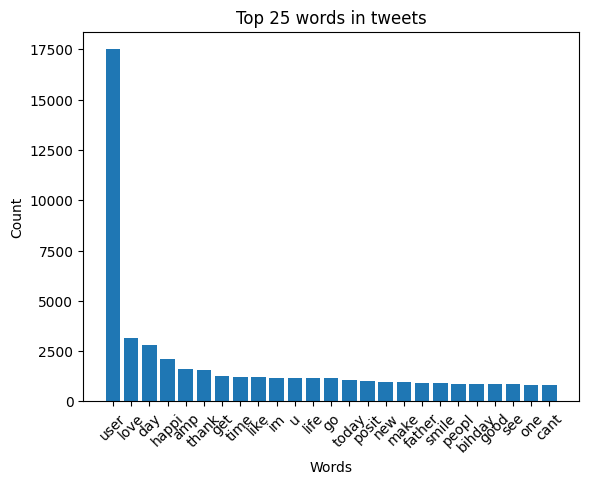

In [83]:
import matplotlib.pyplot as plt

# Get the N most common words and their counts
N = 25
top_words = word_counts.most_common(N)

# Split the list of tuples into two lists: one for words and one for counts
words, counts = zip(*top_words)

# Create a bar plot
plt.bar(words, counts)

# Add title and labels
plt.title('Top {} words in tweets'.format(N))
plt.xlabel('Words')
plt.ylabel('Count')

# Rotate the X-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()



In [84]:
# Count the number of each label
label_counts = df_train['label'].value_counts()

# Get the number of label 1
num_label_1 = label_counts[1]

# Get the total number of labels
total_labels = len(df_train)

# Calculate the percentage
percentage_label_1 = (num_label_1 / total_labels) * 100

print("Number of label 1: ", num_label_1)
print("Percentage of hate speech in training set is: ", percentage_label_1, "%")


Number of label 1:  2242
Percentage of hate speech in training set is:  7.014579813528565 %


## Vectorization

### TFIDF to vectorize

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=500)#500 features
content_vectors = vectorizer.fit_transform(df_train['tweet'].values.astype('U'))#change to unicode, then fit
content_vectors_array = content_vectors.toarray()#convert to array
tweet_vectors_tfidf = pd.DataFrame(content_vectors_array)
tweet_vectors_tfidf.head(2)


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Word2Vec to vectorize

In [86]:
from gensim.models import Word2Vec
import nltk

sentenses = df_train['tweet'].apply(nltk.word_tokenize)

In [87]:
#train the Word2vec model
model = Word2Vec(sentenses,vector_size=500, window=5, min_count=1, workers=4)#500 features

In [88]:
def get_text_vector(model, text):
    words = nltk.word_tokenize(text)#tokenize
    word_vectors = [model.wv[word] for word in words if word in model.wv]#convert to vectors

    if not word_vectors:
        return np.zeros(model.vector_size)#if all words not in model.wv,return 0 for each dimension
    return np.mean(word_vectors, axis=0)#average the vectors

tweet_vectors_word2vec = df_train['tweet'].apply(lambda x: get_text_vector(model, x))


In [89]:
tweet_vectors_word2vec = pd.DataFrame(tweet_vectors_word2vec)
tweet_vectors_word2vec.head(2)

,tweet
0,"[0.23847789, 0.2897436, 0.36158496, 0.255058, ..."
1,"[0.19806203, 0.2026228, 0.3038976, 0.28351724,..."


## BERT to vectorize

In [90]:
from transformers import BertModel, BertTokenizer
import torch

# Load pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# If there's a GPU available...
if torch.cuda.is_available():

    #Use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# move the model to the GPU
model = model.to(device)

# Define a function to encode text
def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
    # Take the vector corresponding to the [CLS] token as the sentence representation
    sentence_vector = outputs[0][0, 0].cpu().numpy() #move tensor to cpu then convert to numpy
    return sentence_vector


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [91]:
# split into 5 batchs
num_batches = 5
batches = np.array_split(df_train, num_batches)


tweet_vectors_BERT = []

for i, batch in enumerate(batches):
    print(f"Processing batch {i+1}/{num_batches}")
    # encode batches
    batch_vectors = batch['tweet'].apply(encode_text)
    tweet_vectors_BERT.extend(batch_vectors)

tweet_vectors_BERT = pd.DataFrame(tweet_vectors_BERT)
print(tweet_vectors_BERT)#dimension = 768

Processing batch 1/5
Processing batch 2/5
Processing batch 3/5
Processing batch 4/5
Processing batch 5/5
            0         1         2         3         4         5         6    \
0     -0.386235  0.066184 -0.103589 -0.189652 -0.303150 -0.156460  0.450781   
1     -0.268751  0.070018  0.071715 -0.129258 -0.039266 -0.265169  0.543793   
2     -0.849660  0.354844 -0.534522  0.001420 -0.586002  0.448913  0.594105   
3     -0.328738  0.055684  0.019677 -0.056584 -0.264892 -0.005369  0.793279   
4     -0.019981 -0.024188 -0.086438 -0.100586  0.027942 -0.278598  0.108005   
...         ...       ...       ...       ...       ...       ...       ...   
31957 -0.202192  0.192212  0.045717 -0.089432 -0.324905 -0.135017  0.381750   
31958 -0.251574  0.158288  0.044507 -0.041987 -0.425812  0.018285  0.354562   
31959 -0.037487  0.038188 -0.021980 -0.545577 -0.533912 -0.284397  0.543170   
31960 -0.202919 -0.052831 -0.070516 -0.467227 -0.424013  0.046555  0.525880   
31961  0.067139  0.217213 

## Exploratary Data Analysis

### 1. Length of tweets

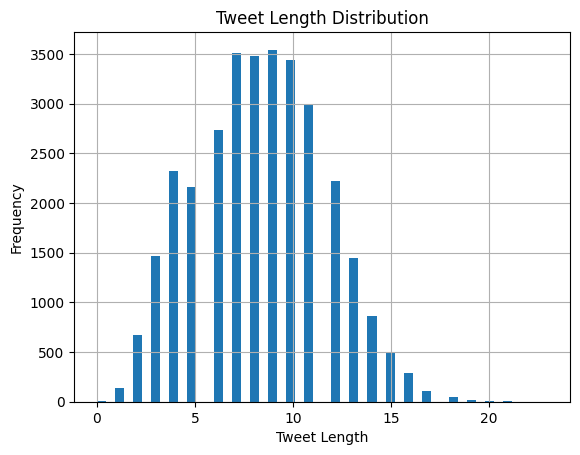

In [92]:
df_train['length_tweet'] = df_train['tweet'].apply(lambda x: len(x.split()))
df_train['length_tweet'].describe()
df_train['length_tweet'].hist(bins=50)

plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


### 2. Analysis of Common Words

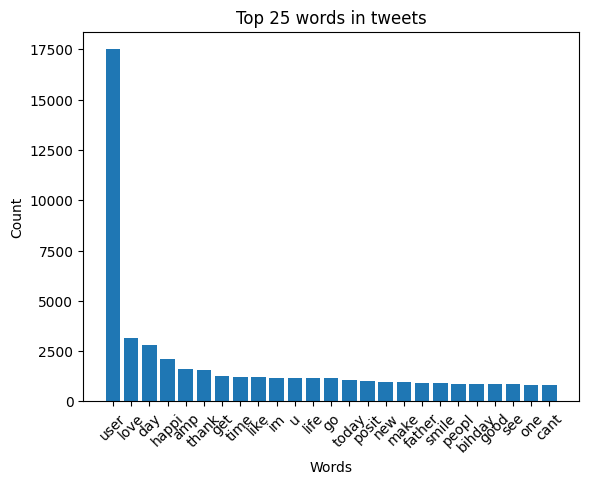

In [93]:
# Get the N most common words and their counts
N = 25
top_words = word_counts.most_common(N)

# Split the list of tuples into two lists: one for words and one for counts
words, counts = zip(*top_words)

# Create a bar plot
plt.bar(words, counts)

# Add title and labels
plt.title('Top {} words in tweets'.format(N))
plt.xlabel('Words')
plt.ylabel('Count')

# Rotate the X-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [94]:
from nltk import ngrams

bigrams = [bigram for tweet in df_train['tweet'] for bigram in ngrams(word_tokenize(tweet), 2)]
# Get the frequency of each bigram
bigram_freq = Counter(bigrams)

print(bigram_freq.most_common(10))


[(('user', 'user'), 4201), (('father', 'day'), 643), (('thank', 'posit'), 404), (('posit', 'affirm'), 352), (('love', 'u'), 346), (('cant', 'wait'), 335), (('u', 'take'), 327), (('take', 'u'), 326), (('u', 'time'), 326), (('model', 'love'), 325)]


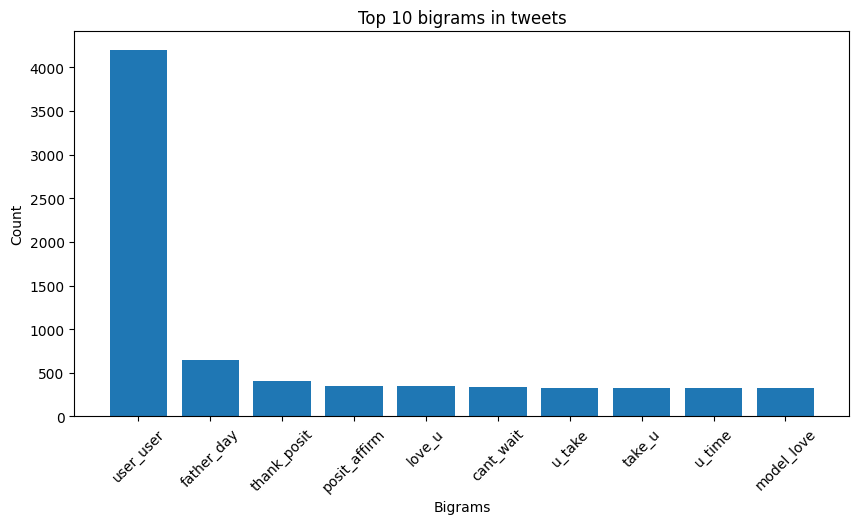

In [95]:
# Get the N most common bigrams and their counts
N = 10
top_bigrams = bigram_freq.most_common(N)

# Split the list of tuples into two lists: one for words and one for counts
bigrams, bigram_counts = zip(*top_bigrams)

# Convert each bigram to a string and join them with an underscore
bigrams_str = ["_".join(bigram) for bigram in bigrams]

# Create a bar plot
plt.figure(figsize=(10, 5))  # Set the figure size
plt.bar(bigrams_str, bigram_counts)

# Add title and labels
plt.title('Top {} bigrams in tweets'.format(N))
plt.xlabel('Bigrams')
plt.ylabel('Count')

# Rotate the X-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

### 3.Categories of mood

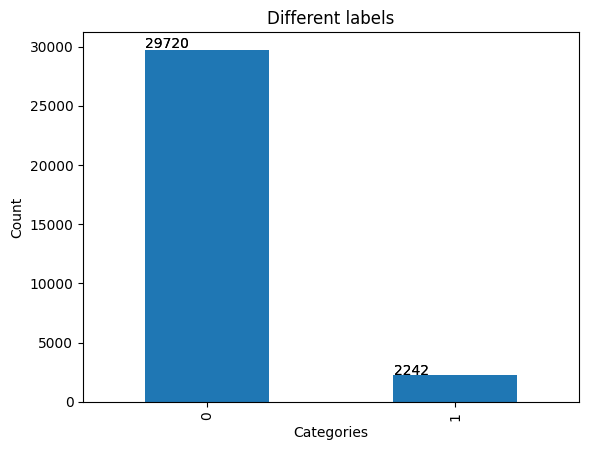

In [96]:
ax = df_train['label'].value_counts().plot(kind='bar')
df_train['label'].value_counts().plot(kind='bar')
plt.title('Different labels'.format(N))
plt.xlabel('Categories')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()#0 means normal speech and 1 means hate speech

### 4.Word clouds

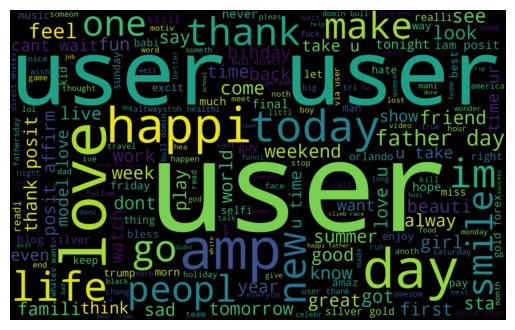

In [97]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(width=1600, height=1000).generate(' '.join(df_train['tweet']))

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

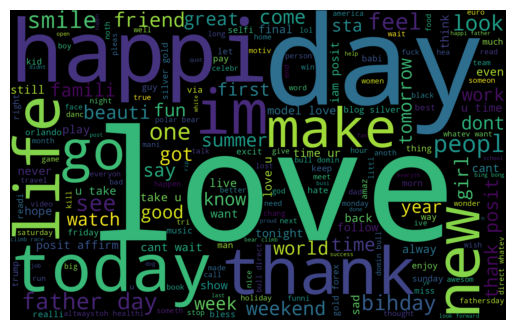

In [98]:
#Without 'user'
from wordcloud import WordCloud, STOPWORDS
# Define a set of stopwords
stopwords = set(STOPWORDS)
stopwords.add('user')  # Add 'user' to the set of stopwords
stopwords.add('amp')
# Generate word cloud
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=1000).generate(' '.join(df_train['tweet']))

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

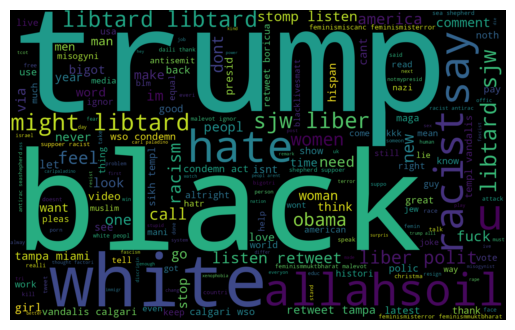

In [99]:
#Word cloud of hate speeches
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=1000).generate(' '.join(df_train[df_train['label'] == 1]['tweet']))

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 5.Explore topics

#### 5.1 All tweets

In [100]:
##all the tweets
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# new stopwords list
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(['user', 'amp'])


vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
dtm = vectorizer.fit_transform(df_train['tweet'])

#LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(dtm)

# top 10 words
for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for hate speech Topic #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for hate speech Topic #0
['look', 'dad', 'fathersday', 'today', 'life', 'bihday', 'love', 'father', 'happi', 'day']


Top 10 words for hate speech Topic #1
['na', 'home', 'know', 'dont', 'model', 'im', 'ur', 'wait', 'love', 'time']


Top 10 words for hate speech Topic #2
['sex', 'live', 'season', 'want', 'place', 'black', 'climb', 'polar', 'race', 'bear']


Top 10 words for hate speech Topic #3
['today', 'alway', 'bless', 'nice', 'grate', 'love', 'iam', 'affirm', 'posit', 'thank']


Top 10 words for hate speech Topic #4
['think', 'morn', 'dont', 'friday', 'good', 'make', 'peopl', 'weekend', 'feel', 'like']


Top 10 words for hate speech Topic #5
['friday', 'friend', 'fun', 'cute', 'beauti', 'happi', 'follow', 'work', 'smile', 'love']


Top 10 words for hate speech Topic #6
['bing', 'im', 'beach', 'peopl', 'good', 'shoot', 'sun', 'trump', 'orlando', 'summer']


Top 10 words for hate speech Topic #7
['im', 'ye', 'use', 'tweet', 'way', 'final', 'forex', 'silver', 'gold', 'blo

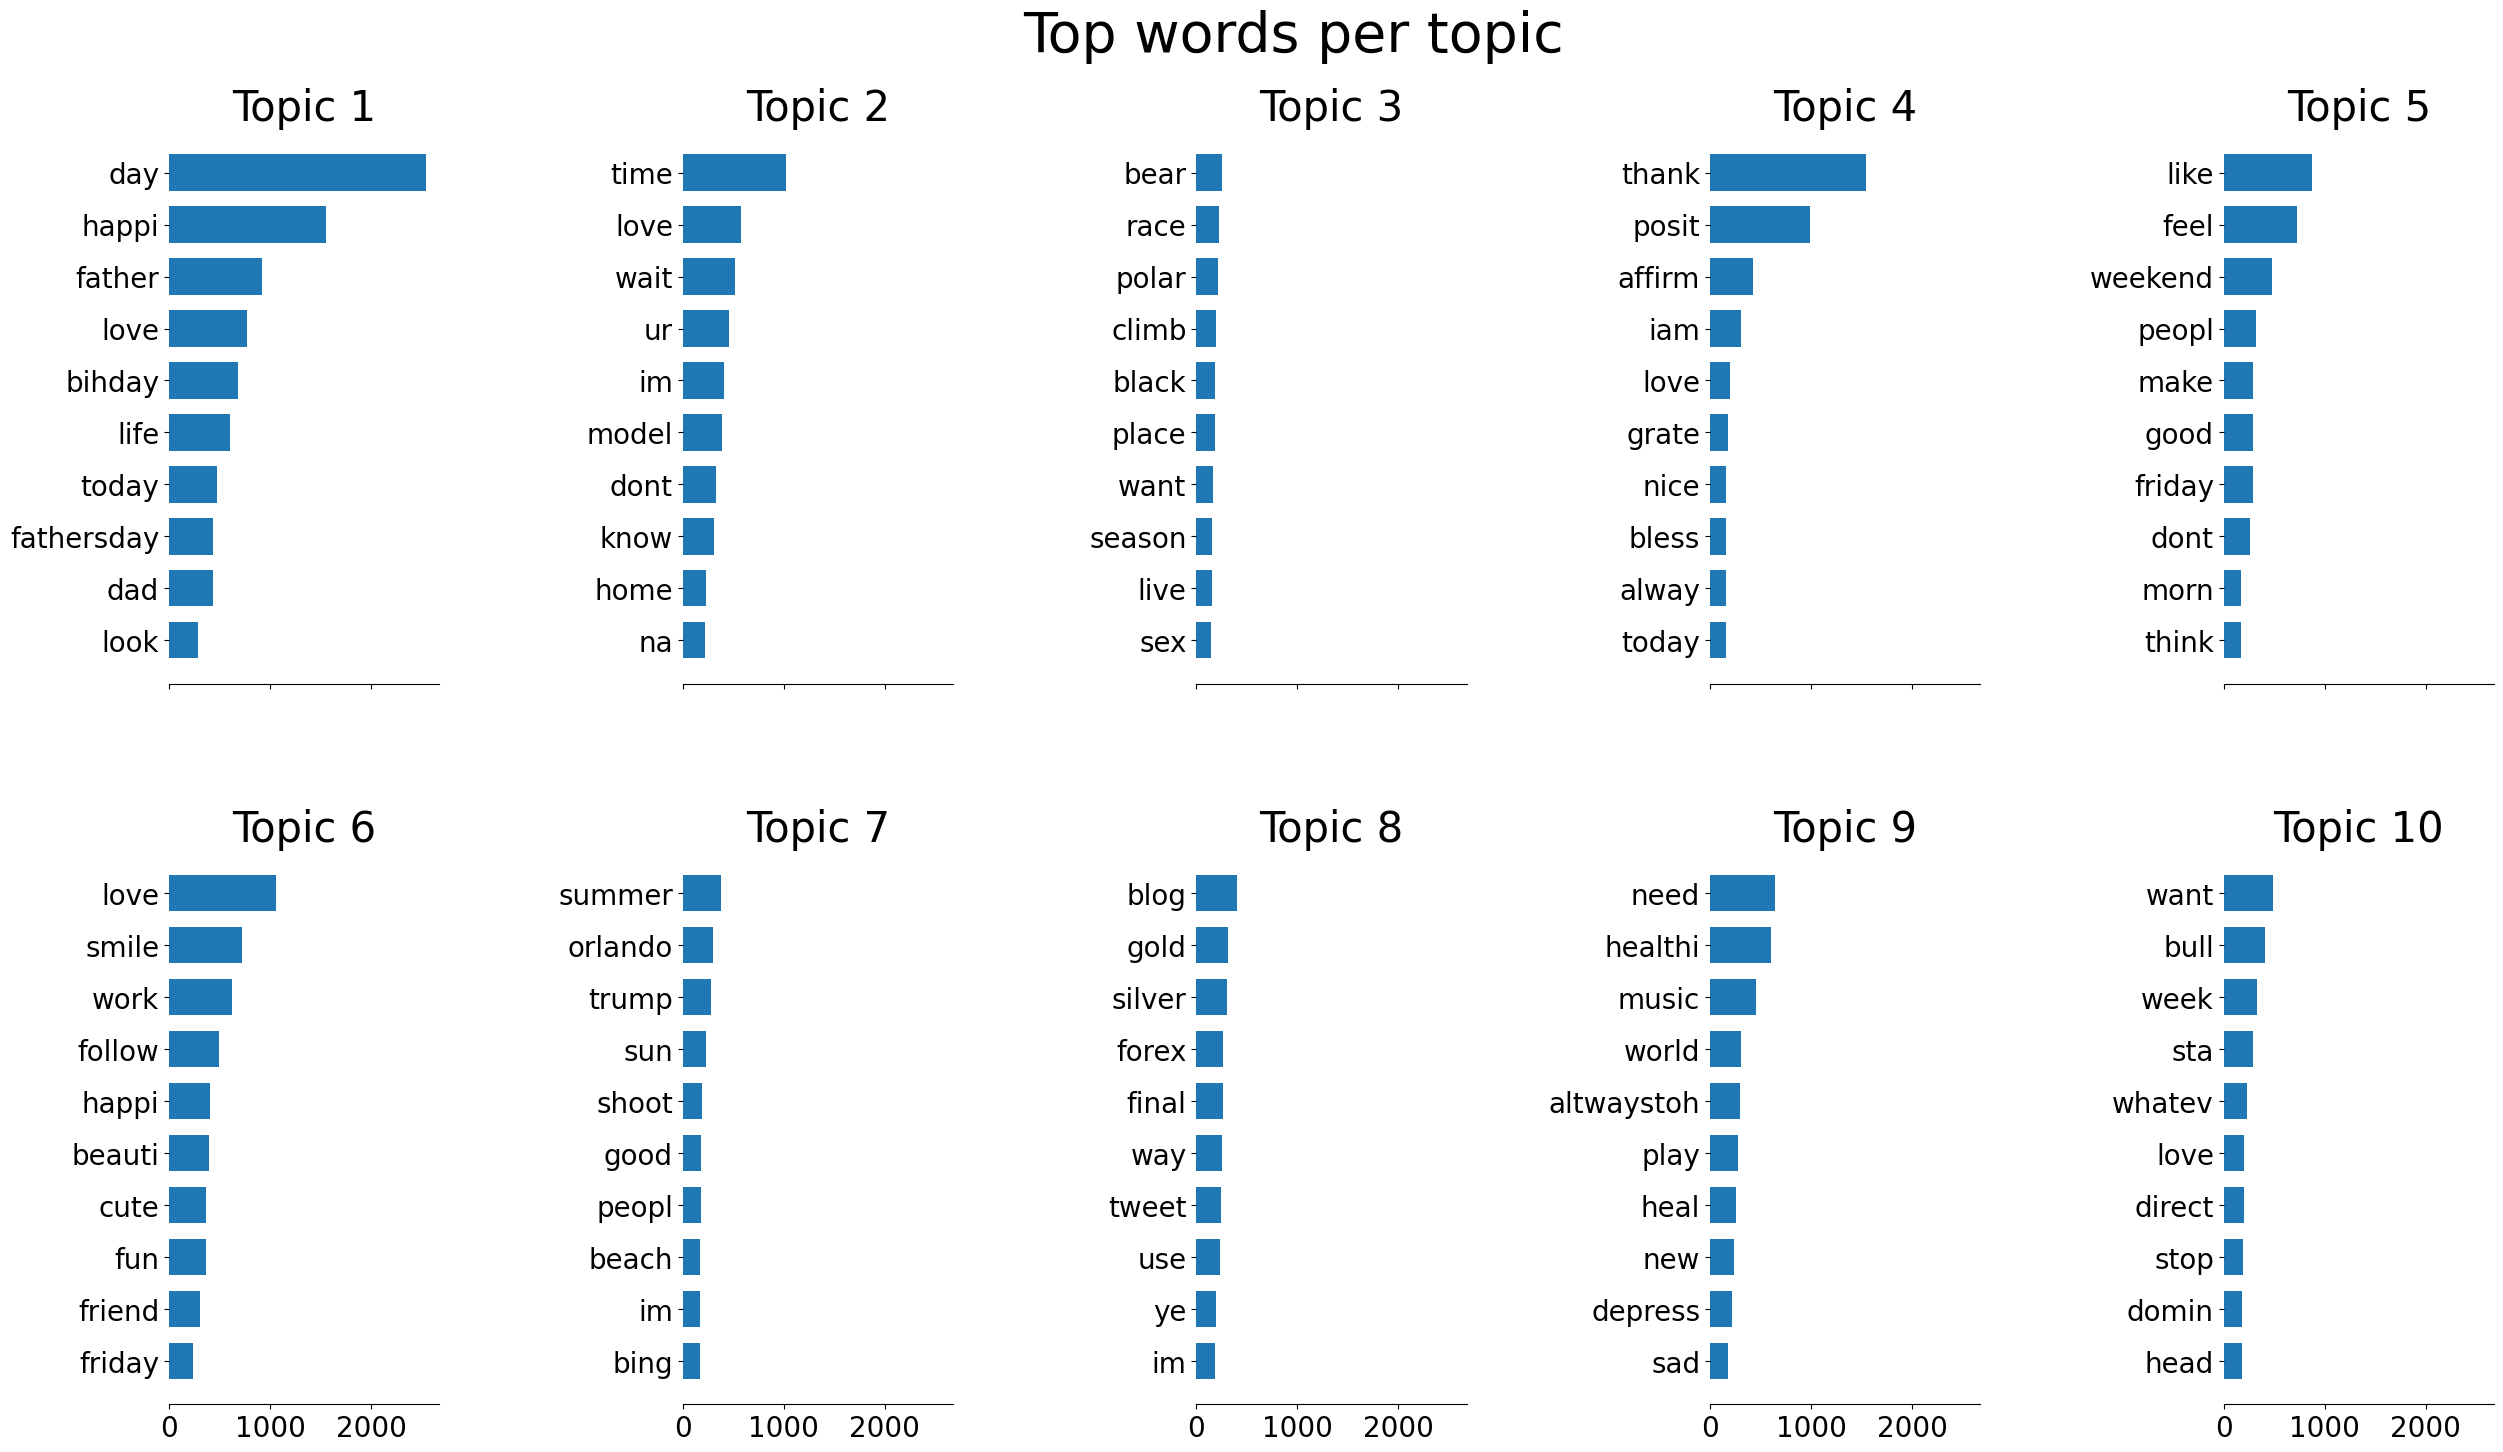

In [101]:
## plot of the common words for all tweets
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words per topic', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names, n_top_words)

#### 5.2 Hate speech

In [102]:
##hate speech
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# create a new stopwords list
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(['user', 'amp'])

# vectorize
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
dtm = vectorizer.fit_transform(df_train[df_train['label'] == 1]['tweet'])

# implement LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(dtm)

# top 10 words
for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for hate speech Topic #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')


Top 10 words for hate speech Topic #0
['word', 'racism', 'way', 'doesnt', 'peopl', 'man', 'dont', 'race', 'black', 'white']


Top 10 words for hate speech Topic #1
['color', 'death', 'love', 'dont', 'allahsoil', 'think', 'god', 'peopl', 'hate', 'need']


Top 10 words for hate speech Topic #2
['equal', 'believ', 'world', 'pay', 'comment', 'right', 'sjw', 'polit', 'liber', 'libtard']


Top 10 words for hate speech Topic #3
['white', 'hispan', 'tampa', 'miami', 'stomp', 'black', 'listen', 'retweet', 'feel', 'like']


Top 10 words for hate speech Topic #4
['messag', 'thing', 'say', 'terror', 'word', 'black', 'men', 'woman', 'allahsoil', 'women']


Top 10 words for hate speech Topic #5
['maga', 'misogyni', 'arent', 'bigotri', 'bigot', 'peopl', 'hatr', 'im', 'new', 'trump']


Top 10 words for hate speech Topic #6
['say', 'kkk', 'school', 'daili', 'stop', 'peopl', 'latest', 'thank', 'trump', 'white']


Top 10 words for hate speech Topic #7
['say', 'wso', 'templ', 'vandalis', 'ignor', 'condemn

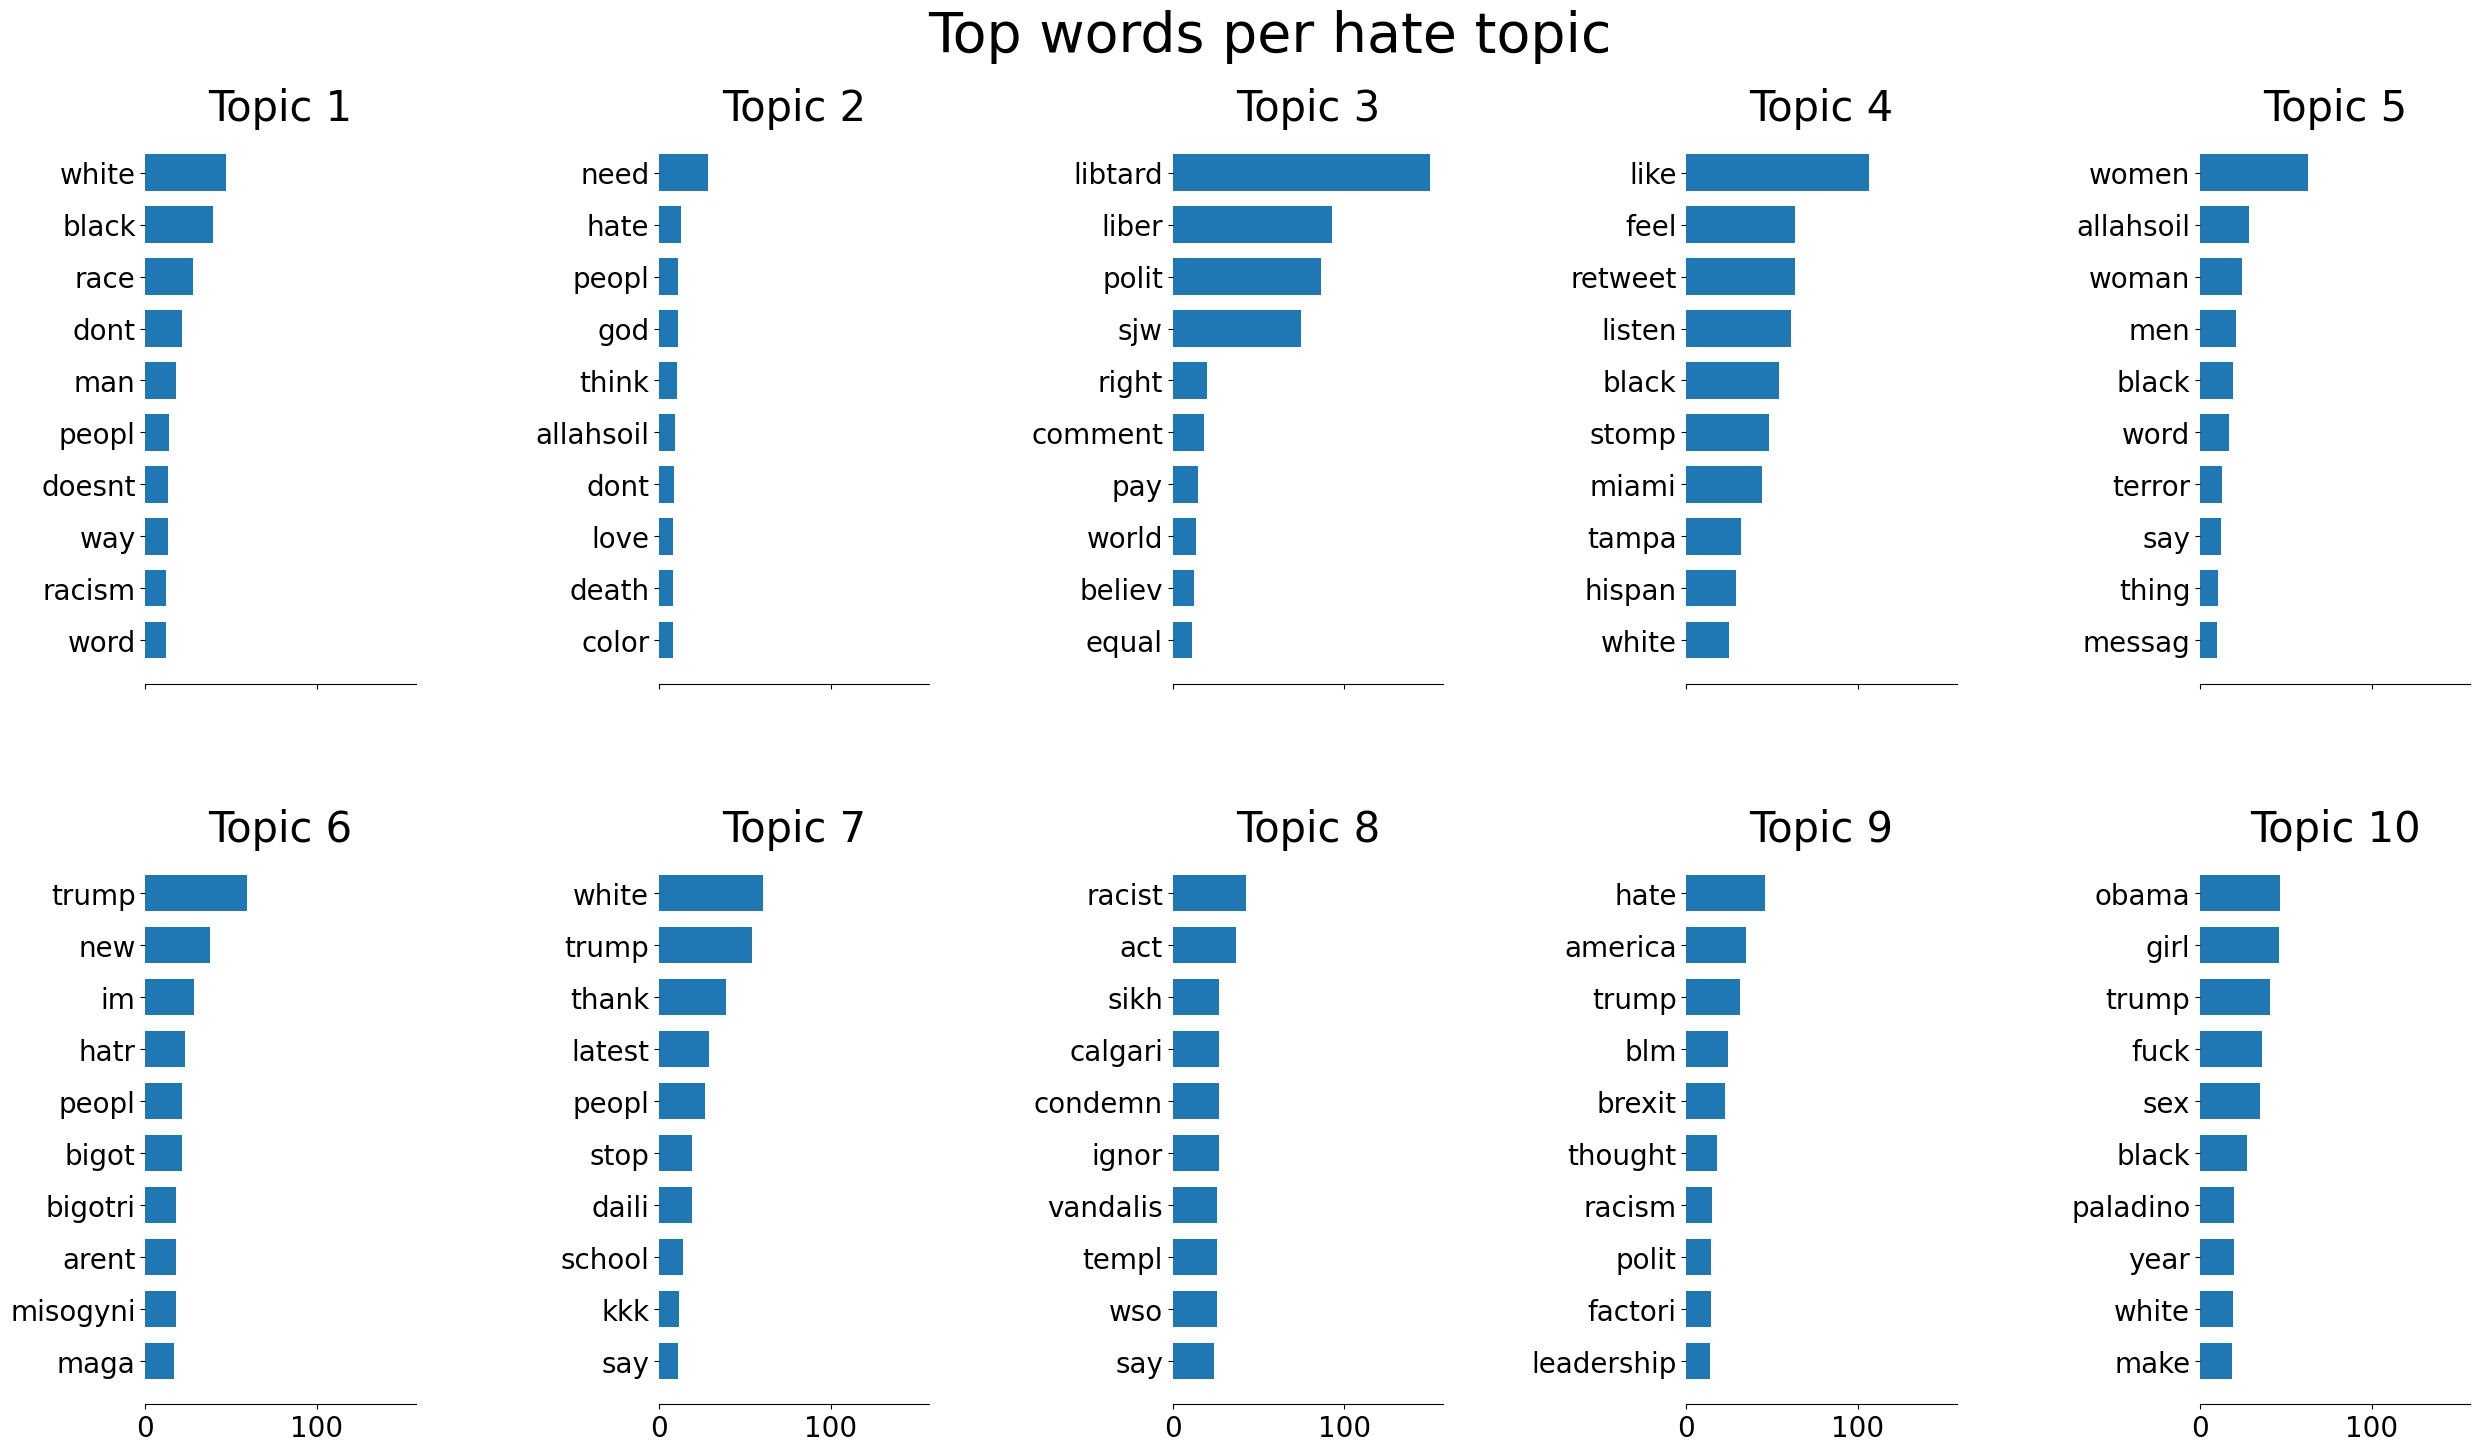

In [103]:
## plot of the common words for hate speech
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words per hate topic', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names, n_top_words)

## Modeling

### 1.Machine Learning

In [104]:
#split into training set and cross validation set
##choose BERT vector as features
from sklearn.model_selection import train_test_split
X_train, X_cross_val, y_train, y_cross_val = train_test_split(tweet_vectors_BERT, df_train['label'], test_size=0.2, random_state = 0)

#### 1.1 Logistic Regression

In [105]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

# make a pipeline
log_reg = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, loss='log',class_weight='balanced'))

# train the model
log_reg.fit(X_train, y_train)

# prediction
y_pred = log_reg.predict(X_cross_val)
y_pred_prob_logreg = log_reg.predict_proba(X_cross_val)[:, 1]

# compute ROC-AUC score
roc_auc = roc_auc_score(y_cross_val, y_pred_prob_logreg)

print(accuracy_score(y_cross_val, y_pred)) #accuracy rate
print(classification_report(y_cross_val, y_pred))
print(f'ROC-AUC score: {roc_auc}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.8126075394963241
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5985
           1       0.22      0.75      0.34       408

    accuracy                           0.81      6393
   macro avg       0.60      0.79      0.62      6393
weighted avg       0.93      0.81      0.86      6393

ROC-AUC score: 0.8709780988418758


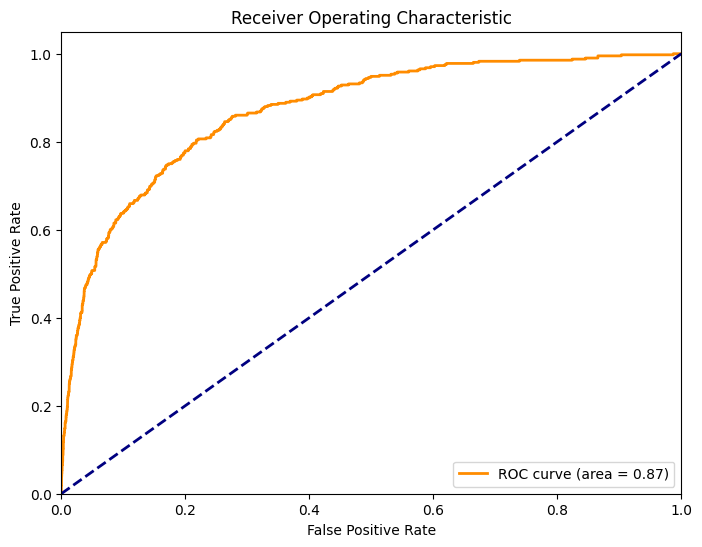

In [106]:
#plot roc_auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# compute the roc curve
fpr, tpr, thresholds = roc_curve(y_cross_val, y_pred_prob_logreg)

# plot the curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### 1.2 Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Create an oversampling object with SMOTE or undersampling object with RandomUnderSampler
smote = SMOTE(sampling_strategy='minority')
#undersample = RandomUnderSampler(sampling_strategy='majority')

# Fit and apply the transform
X_oversample, y_oversample = smote.fit_resample(X_train, y_train)
#X_undersample, y_undersample = undersample.fit_resample(X_train, y_train)

# Initialize RandomForestClassifier and fit the model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_oversample, y_oversample) # or clf.fit(X_undersample, y_undersample)

# Prediction
y_pred = clf.predict(X_cross_val)
y_pred_prob_rf = clf.predict_proba(X_cross_val)[:,1]

# compute ROC-AUC score
roc_auc = roc_auc_score(y_cross_val, y_pred_prob_rf)
# Check the Accuracy score and Classification report
print('Accuracy Score:', accuracy_score(y_cross_val, y_pred))
print(classification_report(y_cross_val, y_pred))
print(f'ROC-AUC score: {roc_auc}')

Accuracy Score: 0.9450961989676209
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5985
           1       0.60      0.40      0.48       408

    accuracy                           0.95      6393
   macro avg       0.78      0.69      0.73      6393
weighted avg       0.94      0.95      0.94      6393

ROC-AUC score: 0.9051798204661982


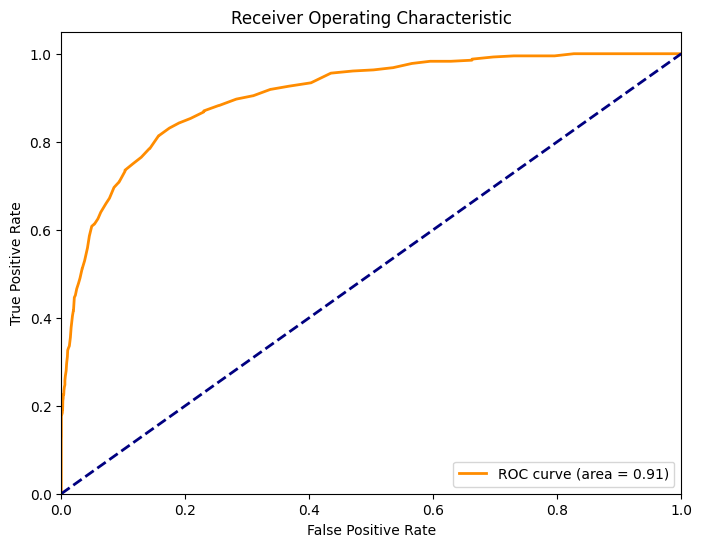

In [108]:
#roc-auc curve
# compute the roc curve
fpr, tpr, thresholds = roc_curve(y_cross_val, y_pred_prob_rf)

# plot the curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### 2.Deep Learning

#### 2.1 Neural Network

In [109]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# create a Sequential model
neural_network = Sequential()

# add the input layer and the first hidden layer
neural_network.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
neural_network.add(Dropout(0.1))
# add the second hidden layer
neural_network.add(Dense(16, activation='relu'))
neural_network.add(Dropout(0.1))
# add the output layer
neural_network.add(Dense(1, activation='sigmoid'))

# compile the model
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model to the training data
neural_network.fit(X_train, y_train, epochs=40, batch_size=10, validation_data=(X_cross_val, y_cross_val))


Epoch 1/40
2557/2557 [==============================] - 11s 4ms/step - loss: 0.1952 - accuracy: 0.9325 - val_loss: 0.1739 - val_accuracy: 0.9376
Epoch 2/40
2557/2557 [==============================] - 9s 4ms/step - loss: 0.1709 - accuracy: 0.9402 - val_loss: 0.1662 - val_accuracy: 0.9387
Epoch 3/40
2557/2557 [==============================] - 9s 4ms/step - loss: 0.1640 - accuracy: 0.9417 - val_loss: 0.1537 - val_accuracy: 0.9471
Epoch 4/40
2557/2557 [==============================] - 10s 4ms/step - loss: 0.1581 - accuracy: 0.9442 - val_loss: 0.1508 - val_accuracy: 0.9474
Epoch 5/40
2557/2557 [==============================] - 9s 4ms/step - loss: 0.1531 - accuracy: 0.9451 - val_loss: 0.1493 - val_accuracy: 0.9509
Epoch 6/40
2557/2557 [==============================] - 9s 4ms/step - loss: 0.1490 - accuracy: 0.9485 - val_loss: 0.1494 - val_accuracy: 0.9498
Epoch 7/40
2557/2557 [==============================] - 9s 4ms/step - loss: 0.1462 - accuracy: 0.9482 - val_loss: 0.1470 - val_accurac

In [110]:
#prediction
y_pred = neural_network.predict(X_cross_val)
y_pred_prob_neural = neural_network.predict(X_cross_val).flatten()
y_pred_class = (y_pred_prob_neural > 0.5).astype(int)
#roc_auc
roc_auc = roc_auc_score(y_cross_val, y_pred_prob_neural)
# Check the Accuracy score and Classification report
print('Accuracy Score:', accuracy_score(y_cross_val, y_pred_class))
print(classification_report(y_cross_val, y_pred_class))
print(f'ROC-AUC score: {roc_auc}')

200/200 [==============================] - 0s 1ms/step
Accuracy Score: 0.9419677772563742
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5985
           1       0.54      0.56      0.55       408

    accuracy                           0.94      6393
   macro avg       0.76      0.77      0.76      6393
weighted avg       0.94      0.94      0.94      6393

ROC-AUC score: 0.8928149622422069


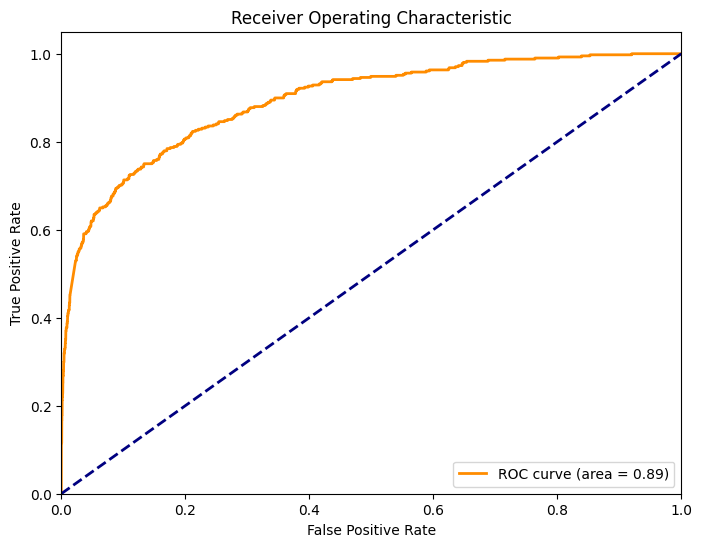

In [111]:
#roc-auc curve
# compute the roc curve
fpr, tpr, thresholds = roc_curve(y_cross_val, y_pred_prob_neural)

# plot the curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### 2.2 BERT

In [112]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load the pre-trained model and tokenizer
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Split your data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_train['tweet'], df_train['label'], test_size=0.2, random_state=42)


# Encode the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Convert our train and test features to InputFeatures that BERT understands.
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.to_numpy()  # use resampled labels
)).shuffle(100).batch(32) # batch size

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test.to_numpy()
)).batch(32) # batch size

# Define the optimizer, loss, and metrics
def weighted_loss(y_true, y_pred):
    class_weight = tf.constant([1., 100.])  # or any other values you chose
    y_true_one_hot = tf.one_hot(y_true, depth=len(class_weight))
    weights = tf.reduce_sum(class_weight * y_true_one_hot, axis=-1)
    unweighted_losses = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    weighted_losses = weights * unweighted_losses
    loss = tf.reduce_mean(weighted_losses)
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=weighted_loss, metrics=[metric])

# Train the model
model.fit(train_dataset, epochs=5)  # adjust epochs as needed

# Evaluate on test set
model.evaluate(test_dataset)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
800/800 [==============================] - 302s 317ms/step - loss: 1.4509 - accuracy: 0.9518
Epoch 2/5
800/800 [==============================] - 247s 309ms/step - loss: 1.0687 - accuracy: 0.9658
Epoch 3/5
800/800 [==============================] - 246s 308ms/step - loss: 0.9863 - accuracy: 0.9718
Epoch 4/5
800/800 [==============================] - 246s 307ms/step - loss: 0.9556 - accuracy: 0.9743
Epoch 5/5
200/200 [==============================] - 22s 97ms/step - loss: 1.8683 - accuracy: 0.9634


[1.8683044910430908, 0.9633974432945251]

200/200 [==============================] - 22s 95ms/step
ROC-AUC score: 0.9302404782378719


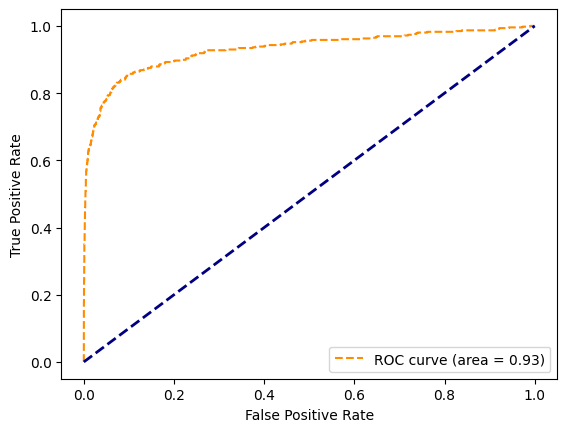

In [113]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# predict probabilities for the test data
y_pred = model.predict(test_dataset)

# we need to extract the probabilities for the positive class
y_pred_prob_BERT = tf.nn.softmax(y_pred[0], axis=-1)[:, 1].numpy()

# compute the roc-auc score
roc_auc = roc_auc_score(y_test, y_pred_prob_BERT)

print('ROC-AUC score:', roc_auc)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_BERT)

# plot the roc curve for the model
plt.plot(fpr, tpr, color='darkorange',linestyle='--', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()


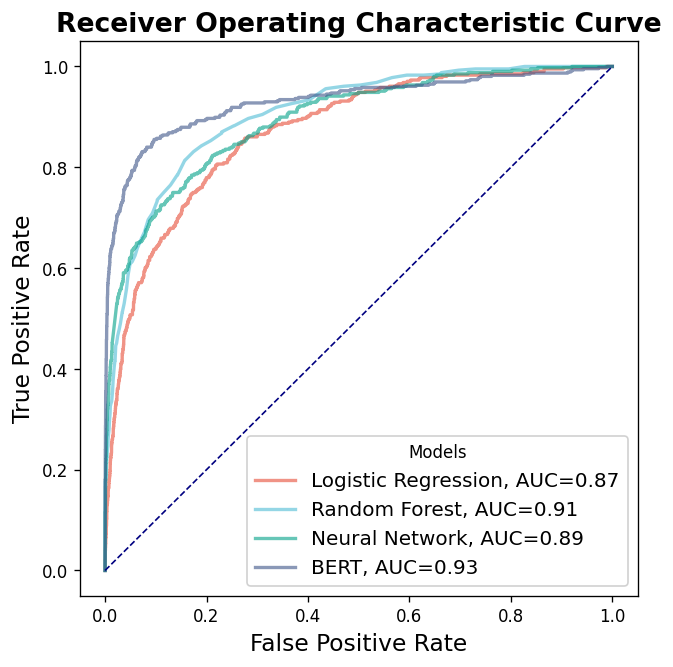

In [114]:
# visualization of the four models
y_pred_prob1 = y_pred_prob_logreg
y_pred_prob2 = y_pred_prob_rf
y_pred_prob3 = y_pred_prob_neural
y_pred_prob4 = y_pred_prob_BERT

#roc_auc curve
fpr1, tpr1, _ = roc_curve(y_cross_val,  y_pred_prob1)
fpr2, tpr2, _ = roc_curve(y_cross_val,  y_pred_prob2)
fpr3, tpr3, _ = roc_curve(y_cross_val,  y_pred_prob3)
fpr4, tpr4, _ = roc_curve(y_test,  y_pred_prob4)

#calculate auc
auc1 = roc_auc_score(y_cross_val, y_pred_prob1)
auc2 = roc_auc_score(y_cross_val, y_pred_prob2)
auc3 = roc_auc_score(y_cross_val, y_pred_prob3)
auc4 = roc_auc_score(y_test, y_pred_prob4)

# Set up the figure size and DPI for a high-res output
plt.figure(figsize=(6, 6), dpi=120)

# Use different colors for different ROC curves
colors = ['#E64B3599', '#4DBBD599', '#00A08799', '#3C548899']

plt.plot(fpr1, tpr1, color=colors[0], lw=2, linestyle='-',
         label="Logistic Regression, AUC="+str(round(auc1, 2)))
plt.plot(fpr2, tpr2, color=colors[1], lw=2, linestyle='-',
         label="Random Forest, AUC="+str(round(auc2, 2)))
plt.plot(fpr3, tpr3, color=colors[2], lw=2, linestyle='-',
         label="Neural Network, AUC="+str(round(auc3, 2)))
plt.plot(fpr4, tpr4, color=colors[3], lw=2, linestyle='-',
         label="BERT, AUC="+str(round(auc4, 2)))

# Customize the grid and the 'diagonal'
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

# Add cosmetics
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic Curve', fontsize=16, fontweight="bold")
plt.legend(loc="lower right", fontsize=12, frameon=True, framealpha=0.9, title="Models")

# Finally plot!
plt.show()



## Implement the model

In [115]:
# to lowercase
df_test['tweet'] = df_test['tweet'].str.lower()
# remove numbers
df_test['tweet'] = df_test['tweet'].astype(str).str.replace(r"\d+", " ")
#remove punctuations
import re
r='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
df_test['tweet'] = df_test['tweet'].apply(lambda tweet: re.sub(r, '', tweet))
# remove whitespaces
df_test['tweet'] = df_test['tweet'].str.strip()
# remove non_ascii characters
df_test['tweet'] = df_test['tweet'].apply(
                    lambda x: x.encode("ascii", errors="ignore").decode()
                )
# remove html characters
df_test['tweet'] = df_test['tweet'].str.replace(r"<[^<>]*>", "", regex=True)
#tokenization
import nltk
nltk.download('punkt')
df_test['tweet'] = df_test['tweet'].apply(word_tokenize)
from nltk.corpus import stopwords
nltk.download('stopwords')

#stopwords
stop_words = set(stopwords.words("english"))

df_test['tweet'] = df_test['tweet'].apply(
                    lambda tokens: [word for word in tokens if not word in stop_words]
                    )
# stemming
stemmer = PorterStemmer()
df_test['tweet'] = df_test['tweet'].apply(
                    lambda tokens: [stemmer.stem(token) for token in tokens])
#rejoin
df_test['tweet'] = df_test['tweet'].str.join(" ")

<ipython-input-115-c01ff6c77ab0>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['tweet'] = df_test['tweet'].astype(str).str.replace(r"\d+", " ")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
#implement the pre-trained BERT model

X_test = df_test['tweet']
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
)).batch(32) # batch size 32

y_pred_BERT = model.predict(test_dataset)
print(y_pred_BERT)

538/538 [==============================] - 54s 96ms/step
TFSequenceClassifierOutput(loss=None, logits=array([[ 2.0858605, -2.863854 ],
       [-2.5303023,  1.4999173],
       [ 2.0864913, -2.8644335],
       ...,
       [ 2.085916 , -2.863904 ],
       [ 2.0857894, -2.8637884],
       [ 2.0856168, -2.8636231]], dtype=float32), hidden_states=None, attentions=None)


In [119]:
import numpy as np

# Extract logits from the output
logits = y_pred_BERT.logits

# Convert logits to probabilities
probabilities = tf.nn.softmax(logits, axis=-1)

# Get predicted class as the one with the highest probability
predictions = tf.cast(probabilities[:, 1] > 0.5, dtype=tf.int32)
print(sum(predictions))


tf.Tensor(781, shape=(), dtype=int32)


In [120]:
df_test_with_prediction = df_test.copy()
df_test_with_prediction['prediction'] = predictions
df_test_with_prediction


,id,tweet,prediction
0,31963,studiolif aislif requir passion dedic willpow ...,0
1,31964,user white supremacist want everyon see new bi...,1
2,31965,safe way heal acn altwaystoh healthi heal,0
3,31966,hp curs child book reserv alreadi ye harrypott...,0
4,31967,rd bihday amaz hilari nephew eli ahmir uncl da...,0
...,...,...,...
17192,49155,thought factori leftright polaris trump uselec...,1
17193,49156,feel like mermaid hairflip neverreadi formal w...,0
17194,49157,hillari campaign today ohioomg amp use word li...,0
17195,49158,happi work confer right mindset lead cultureof...,0
